In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

### _Dataset_

In [7]:
# mu+mu- data (current)
input_dir = 'train_all'

In [8]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [9]:
file_prefixes[:10]

['train_all/event0000000000',
 'train_all/event0000000001',
 'train_all/event0000000002',
 'train_all/event0000000003',
 'train_all/event0000000004',
 'train_all/event0000000005',
 'train_all/event0000000006',
 'train_all/event0000000007',
 'train_all/event0000000008',
 'train_all/event0000000009']

In [10]:
event_id = 1
event_prefix = file_prefixes[event_id]

In [11]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000001 memory usage 0.03 MB


In [12]:
hits.head()

hit_id        x          y     z  volume_id  layer_id  module_id
0       1 -7.87217  14.645000  35.0          9         0          7
1       2 -8.74686  15.150000  35.0          9         1        112
2       3 -8.74686  16.160000  35.0          9         2        222
3       4 -9.62154  16.665001  35.0          9         3        339
4       5 -9.62154  17.674999  35.0          9         4        461

In [13]:
tubes.head()

hit_id  isochrone   depcharge  energyloss  volume_id  layer_id  module_id  \
0       1   0.312154   8106480.0     8.10648          9         0          7   
1       2   0.243986   4438520.0     4.43852          9         1        112   
2       3   0.227273  12218100.0    12.21810          9         2        222   
3       4   0.326345   4719830.0     4.71983          9         3        339   
4       5   0.112023  12483800.0    12.48380          9         4        461   

   skewed  sector_id  
0       0          0  
1       0          0  
2       0          0  
3       0          0  
4       0          0

In [14]:
particles.head()

particle_id   vx   vy   vz        px        py        pz  q  nhits  \
0            1  0.0  0.0  0.0 -0.467824  0.843642 -0.308224  1     26   
1            2  0.0  0.0  0.0 -0.295066  0.393566 -0.364931  1     25   
2            3  0.0  0.0  0.0 -0.266403  0.004486  0.150829  1     27   
3            4  0.0  0.0  0.0  0.004641  0.066527  0.119620  1     40   
4            5  0.0  0.0  0.0  0.193790  0.088343  0.188068  1     23   

   pdgcode  start_time  
0       13           0  
1       13           0  
2       13           0  
3       13           0  
4       13           0

In [15]:
truth.head()

hit_id       tx         ty       tz       tpx       tpy       tpz  weight  \
0       1 -8.14818  14.503100 -12.1190 -0.304760  0.592697 -0.481614     1.0   
1       2 -8.53445  15.258200 -12.7318 -0.302497  0.593937 -0.481471     1.0   
2       3 -8.94150  16.061899 -13.3825 -0.299945  0.595248 -0.481365     1.0   
3       4 -9.31965  16.815701 -13.9915 -0.297617  0.596324 -0.481449     1.0   
4       5 -9.72147  17.625601 -14.6446 -0.295214  0.597517 -0.481419     1.0   

   particle_id  
0           10  
1           10  
2           10  
3           10  
4           10

### _Build Event_

In [16]:
from src import Compose_Event, Draw_Compose_Event

In [17]:
event = Compose_Event(event_prefix)

In [18]:
event.shape

(242, 25)

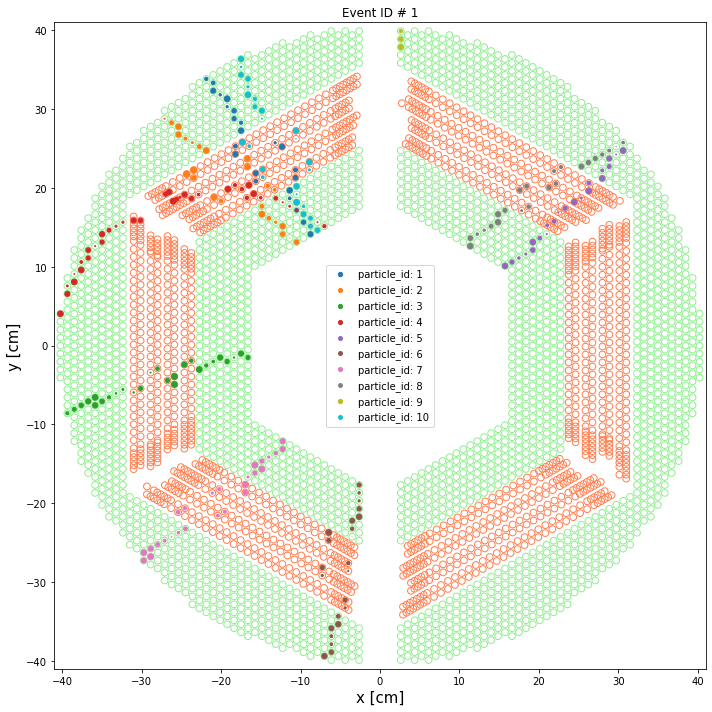

In [19]:
Draw_Compose_Event(event, figsize=(10, 10), save_fig=True);

### SttCSVReader

In [20]:
from src import SttCSVReader, Draw_Reader_Event

In [21]:
csv_reader = SttCSVReader(input_dir, True, True)

In [22]:
data = csv_reader(event_id)

In [23]:
data.hits.head()

hit_id        x          y     z  volume_id  layer_id  module_id  \
0       1 -7.87217  14.645000  35.0          9         0          7   
1       2 -8.74686  15.150000  35.0          9         1        112   
2       3 -8.74686  16.160000  35.0          9         2        222   
3       4 -9.62154  16.665001  35.0          9         3        339   
4       5 -9.62154  17.674999  35.0          9         4        461   

   isochrone  skewed  sector_id  event_id  
0   0.312154       0          0         1  
1   0.243986       0          0         1  
2   0.227273       0          0         1  
3   0.326345       0          0         1  
4   0.112023       0          0         1

In [24]:
data.hits.shape

(242, 11)

In [25]:
data.hits.layer_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32)

In [26]:
data.event_file

'/home/adeel/current/3_deeptrkx/ctd2022/train_all/event0000000001'

In [27]:
data.event.head()

hit_id        x          y     z  volume_id  layer_id  module_id  \
0       1 -7.87217  14.645000  35.0          9         0          7   
1       2 -8.74686  15.150000  35.0          9         1        112   
2       3 -8.74686  16.160000  35.0          9         2        222   
3       4 -9.62154  16.665001  35.0          9         3        339   
4       5 -9.62154  17.674999  35.0          9         4        461   

   isochrone  skewed  sector_id  ...  pdgcode  start_time       pt      peta  \
0   0.312154       0          0  ...      -13           0  0.67161 -0.677819   
1   0.243986       0          0  ...      -13           0  0.67161 -0.677819   
2   0.227273       0          0  ...      -13           0  0.67161 -0.677819   
3   0.326345       0          0  ...      -13           0  0.67161 -0.677819   
4   0.112023       0          0  ...      -13           0  0.67161 -0.677819   

           r       phi       eta         r3  absZ       tpt  
0  16.626699  2.064018  1.489651  38.748512  35.0  0.666460  
1  17.493713  2.094395  1.443957  39.128380  35.0  0.666533  
2  18.375341  2.066909  1.400198  39.530407  35.0  0.666549  
3  19.243084  2.094395  1.359552  39.941158  35.0  0.666467  
4  20.124105  2.069298  1.320531  40.373005  35.0  0.666467  

[5 rows x 37 columns]

In [28]:
data.particles

particle_id   vx   vy   vz        px        py        pz  q  nhits  \
0            1  0.0  0.0  0.0 -0.467824  0.843642 -0.308224  1     26   
1            2  0.0  0.0  0.0 -0.295066  0.393566 -0.364931  1     25   
2            3  0.0  0.0  0.0 -0.266403  0.004486  0.150829  1     27   
3            4  0.0  0.0  0.0  0.004641  0.066527  0.119620  1     40   
4            5  0.0  0.0  0.0  0.193790  0.088343  0.188068  1     23   
5            6  0.0  0.0  0.0 -0.117352 -1.085490 -0.722717 -1     23   
6            7  0.0  0.0  0.0 -0.343560 -0.392915  1.166540 -1     26   
7            8  0.0  0.0  0.0  0.125209  0.187978  0.132719 -1     23   
8            9  0.0  0.0  0.0  0.003396  0.976899 -0.541748 -1      3   
9           10  0.0  0.0  0.0 -0.348859  0.573897 -0.490898 -1     26   

   pdgcode  start_time        pt      peta  
0       13           0  0.964671 -0.314311  
1       13           0  0.491892 -0.686648  
2       13           0  0.266441  0.539529  
3       13           0  0.066689  1.347376  
4       13           0  0.212976  0.796212  
5      -13           0  1.091815 -0.621209  
6      -13           0  0.521935  1.544062  
7      -13           0  0.225861  0.558176  
8      -13           0  0.976905 -0.529468  
9      -13           0  0.671610 -0.677819

## _Detector Layout_

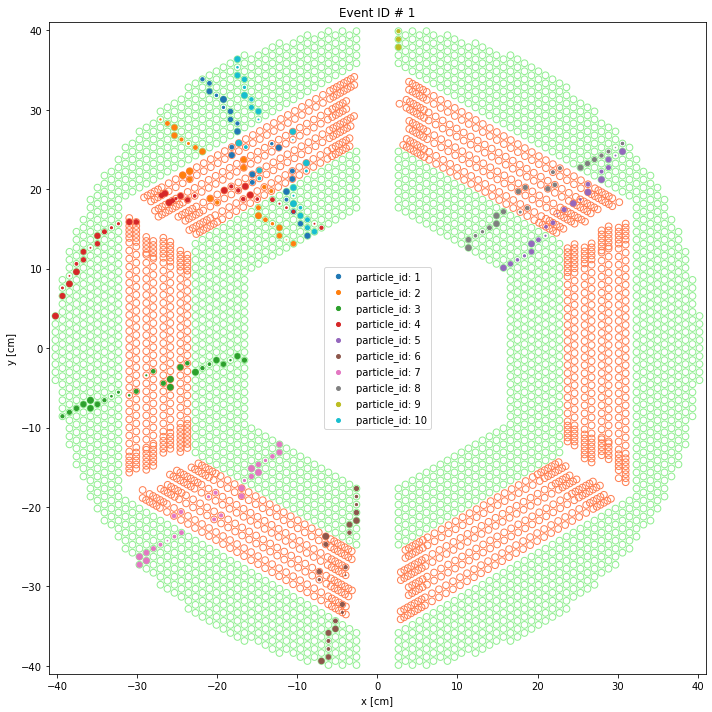

In [29]:
Draw_Reader_Event(data, figsize=(10,10));

## _Plot True & False Edges_

- processed events from the `feature_store/train`
- code from `notebooks/example_gnn.ipynb`

In [30]:
from src.drawing import detector_layout
from src.utils_math import polar_to_cartesian

In [31]:
event_idx = 1

In [32]:
inputdir="run/feature_store/train"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [33]:
# event_id
proc_files[event_idx]

'run/feature_store/train/1'

In [34]:
feature_data = torch.load(proc_files[event_idx], map_location=device)

In [35]:
# get spatial coordinates, note: x = [x,y,ir]
r, phi, ir = feature_data.x.T

In [36]:
# coord. transform, compensate scaling
x, y = polar_to_cartesian(r, phi)
ir = ir*100

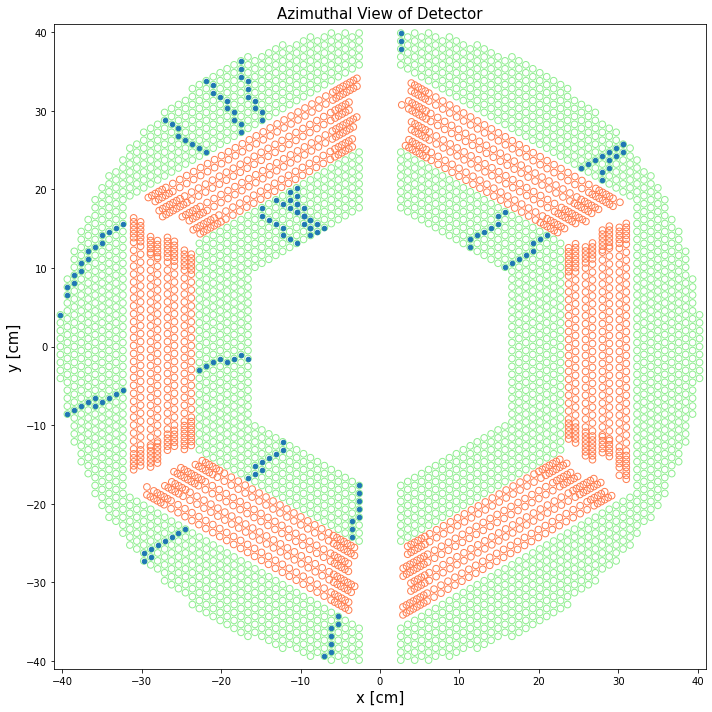

In [37]:
# plot all hits
fig, ax = detector_layout(figsize=(10,10))
ax.scatter(x, y, s=20)

ax.set_title("Azimuthal View of Detector", fontsize=15)
ax.grid(False)
fig.tight_layout()
# fig.savefig('event_{}.png'.format(event_idx))

In [38]:
# get true_edges
e = feature_data.edge_index
pid = feature_data.pid
true_edges = pid[e[0]] == pid[e[1]]

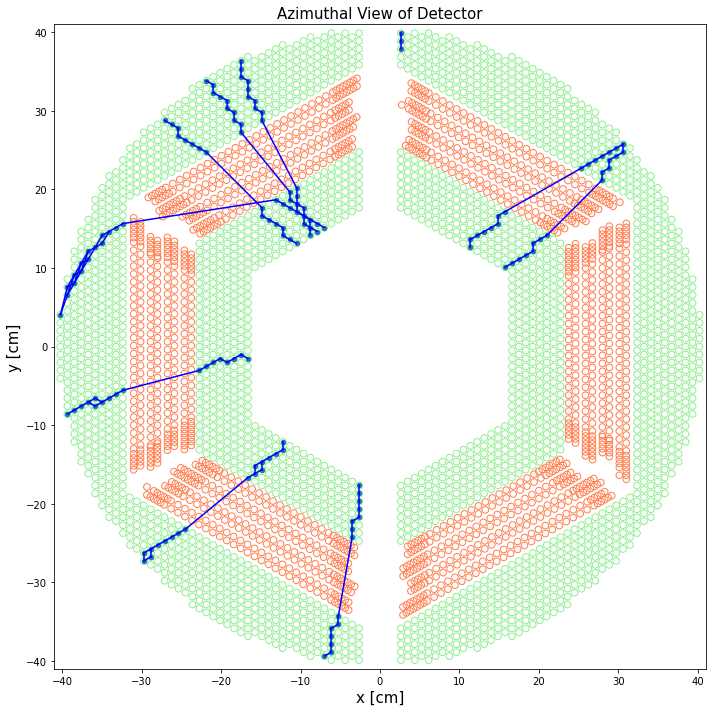

In [39]:
# plot only true edges
fig, ax = detector_layout(figsize=(10,10))

ax.plot(x[e[:, true_edges]], y[e[:, true_edges]], c="b")
ax.scatter(x, y, s=20)

ax.set_title("Azimuthal View of Detector", fontsize=15)
ax.grid(False)
fig.tight_layout()
fig.savefig('true_edges_{}.png'.format(event_idx))

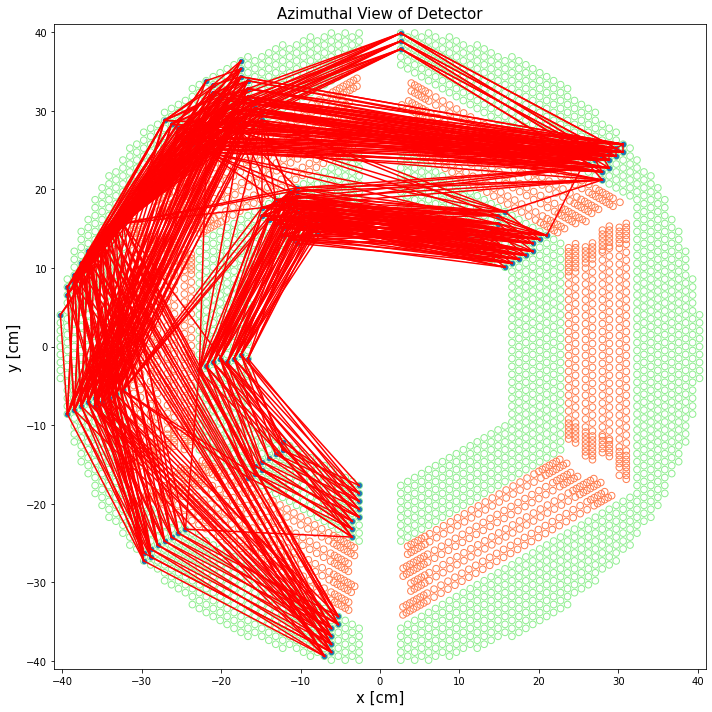

In [40]:
# plot only false edges
fig, ax = detector_layout(figsize=(10,10))

ax.plot(x[e[:, ~true_edges]], y[e[:, ~true_edges]], c="r")
ax.scatter(x, y, s=20)

ax.set_title("Azimuthal View of Detector", fontsize=15)
ax.grid(False)
fig.tight_layout()
fig.savefig('false_edges_{}.png'.format(event_idx))

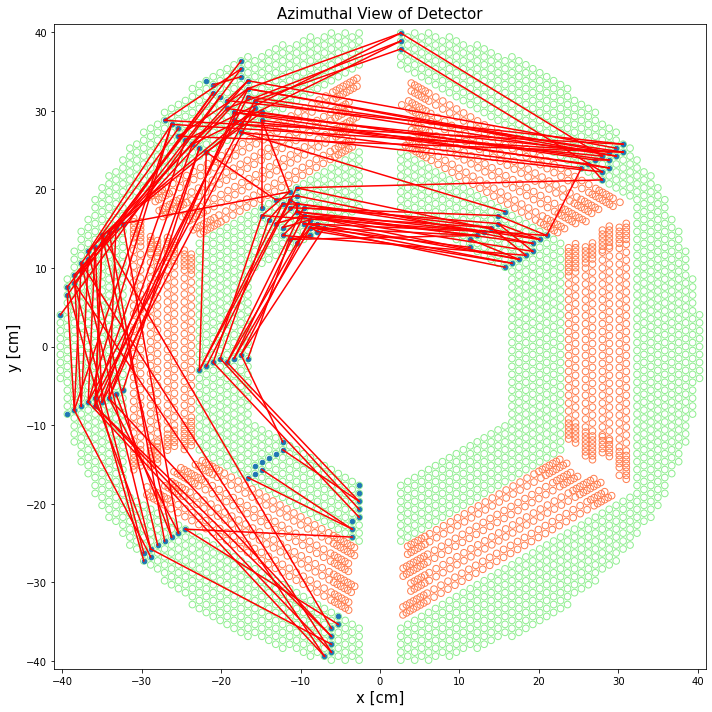

In [41]:
# plot all edges (true + false), only few false edges
fig, ax = detector_layout(figsize=(10,10))

ax.plot(x[e[:, (~true_edges)][:, 0:-1:5]], y[e[:, (~true_edges)][:, 0:-1:5]], c="r")
ax.scatter(x, y, s=20)

ax.set_title("Azimuthal View of Detector", fontsize=15)
ax.grid(False)
fig.tight_layout()
fig.savefig('true_edges_less_{}.png'.format(event_idx))

## _Inspect HDFStore_

- See [IO tools (text, CSV, HDF5, …)](https://pandas.pydata.org/docs/user_guide/io.html)

#### HDF5 Store

- read/write using `pd.HDFStore("path/to/*.h5")`
- read/write using `pd.read_hdf()`, `pd.to_hdf()` similar to `pd.read_csv()` and `pd.to_csv()`
    *. `pd.read_hdf()`: Read from the store, close it if we opened it.
- close when finished

In [42]:
# path to HDF5 Store
hdf5_path = 'run/trkx_reco_eval/eval_particles.h5'

In [43]:
# Method 1: use context manager to open store
with pd.HDFStore(hdf5_path, 'r') as store:
    print(store)

OSError: ``/home/adeel/current/3_deeptrkx/ctd2022/run_100K/trkx_reco_eval/eval_particles.h5`` does not exist

In [ ]:
# Method 2: Use constructor method. Don't forget to close it using store.close()
store = pd.HDFStore(hdf5_path)

In [ ]:
store.groups()

In [ ]:
# get stored dataframe using group
store.get('data').head()

In [ ]:
# OR, get stored dataframe using group
store['data'].head()

In [ ]:
store.close()

In [ ]:
store.is_open

In [ ]:
# Method 3: Retrieve pandas object stored in h5 file
store = pd.read_hdf(hdf5_path)

In [ ]:
store.head()